# Model Evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import httpimport
import joblib

from pathlib import Path
from dmba import gainsChart

from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib 
matplotlib.use('Agg') # Use non-interactive Agg backend

%matplotlib inline

In [3]:
# Import personal library
with httpimport.github_repo("junclemente", "jcds", ref="master"):
    import jcds.metrics as jm
    import jcds.charts as jc

In [4]:
# Import datasets
datasets = Path("../datasets")
df = pd.read_csv(datasets / "school_final_dataset.csv")
display(df.head())

,Undergrad_Degree,Work_Experience,Employability_Before,Status,Status_enc
0,Business,No,252.0,Placed,1
1,Business,No,423.0,Not Placed,0
2,Computer Science,Yes,101.0,Placed,1
3,Engineering,No,288.0,Not Placed,0
4,Finance,No,248.0,Not Placed,0


## Setup Testing and Validation Dataframes

In [5]:
# Variables to use for predictive modeling
variables = ["Undergrad_Degree", "Work_Experience", "Employability_Before"]
target = "Status_enc"

In [6]:
# Setup train and val dataframes
X = df[variables]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# # One-hot encode categorical variables
X_enc = pd.get_dummies(X, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)

# # Standardize cont  / Initialize scaler
scaler = StandardScaler()
std_cols = ["Employability_Before"]

Xs_enc = X_enc.copy()
Xs_enc[std_cols] = scaler.fit_transform(Xs_enc[std_cols])

Xs_train = X_train.copy()
Xs_train[std_cols] = scaler.transform(Xs_train[std_cols])

Xs_val = X_val.copy()
Xs_val[std_cols] = scaler.transform(Xs_val[std_cols])

display(X_enc.head())
display(Xs_enc.head())

,Employability_Before,Undergrad_Degree_Business,Undergrad_Degree_Computer Science,Undergrad_Degree_Engineering,Undergrad_Degree_Finance,Work_Experience_Yes
0,252.0,True,False,False,False,False
1,423.0,True,False,False,False,False
2,101.0,False,True,False,False,True
3,288.0,False,False,True,False,False
4,248.0,False,False,False,True,False


,Employability_Before,Undergrad_Degree_Business,Undergrad_Degree_Computer Science,Undergrad_Degree_Engineering,Undergrad_Degree_Finance,Work_Experience_Yes
0,0.987385,True,False,False,False,False
1,5.717070,True,False,False,False,False
2,-3.189121,False,True,False,False,True
3,1.983108,False,False,True,False,False
4,0.876749,False,False,False,True,False


## Import Predictive Models

In [7]:
models = Path("../models")
dt_model = joblib.load(models / "decision_tree_model.pkl")
knn_model = joblib.load(models / "k_nearest_neighbor_model.pkl")
lr_model = joblib.load(models / "logistic_regression_model.pkl")

## Classification Reports

In [8]:
dt_model.fit(X_train, y_train)
dty_pred = dt_model.predict(X_val)
cm = confusion_matrix(y_val, dty_pred)
jm.mc_confusion(cm)

Confusion Matrix:
[[186  10]
 [ 10 274]]


,Class 0,Class 1
Accuracy,0.95833,0.95833
Error rate,0.04167,0.04167
Sensitivity (Recall),0.94898,0.96479
Specificity,0.96479,0.94898
Precision,0.94898,0.96479
F1,0.94898,0.96479
F2,0.94898,0.96479
F0.5,0.94898,0.96479


In [9]:
knn_model.fit(Xs_train, y_train)
knny_pred = knn_model.predict(Xs_val)
cm = confusion_matrix(y_val, knny_pred)
jm.mc_confusion(cm)

Confusion Matrix:
[[182  14]
 [  6 278]]


,Class 0,Class 1
Accuracy,0.95833,0.95833
Error rate,0.04167,0.04167
Sensitivity (Recall),0.92857,0.97887
Specificity,0.97887,0.92857
Precision,0.96809,0.95205
F1,0.94792,0.96528
F2,0.93621,0.97339
F0.5,0.95992,0.95730


In [10]:
lr_model.fit(Xs_train, y_train)
lry_pred = lr_model.predict(Xs_val)
cm = confusion_matrix(y_val, lry_pred)
jm.mc_confusion(cm)

Confusion Matrix:
[[184  12]
 [  5 279]]


,Class 0,Class 1
Accuracy,0.96458,0.96458
Error rate,0.03542,0.03542
Sensitivity (Recall),0.93878,0.98239
Specificity,0.98239,0.93878
Precision,0.97354,0.95876
F1,0.95584,0.97043
F2,0.94553,0.97758
F0.5,0.96639,0.96340


### Observation
| Metric | Decision Tree | K-Nearest Neighbor | Logistic Regression |
|--------|:-------------:|:------------------:|:-------------------:|
| Accuracy | 0.96 | 0.96 | 0.96 |
| Recall | 0.96 | 0.98 | 0.98 | 
| Precision | 0.96 | 0.95 | 0.96 | 
| F1 Score | 0.96 | 0.97 | 0.97 |

Based on the classification reports, all three models appear to do very well. 
Accuracy is consistent in all models at predicting the target class (Class 1). 
Recall shows how many true positives were correctly identified. The Decision Tree did poorly compared to the other two models. 
Precision shows the percentage of predicted positives were actually correct. 
F1 Score is the harmonic mean of Precision and Recall. This score ensures that lower scores are given more weight and balances the trade-off between the two metrics. As a result, models that perform well in both metrics have a higher F1 score. 

Based on this information, the Logistic Regression model takes a slight win over the KNN model. 

## Accuracy through Cross Validation

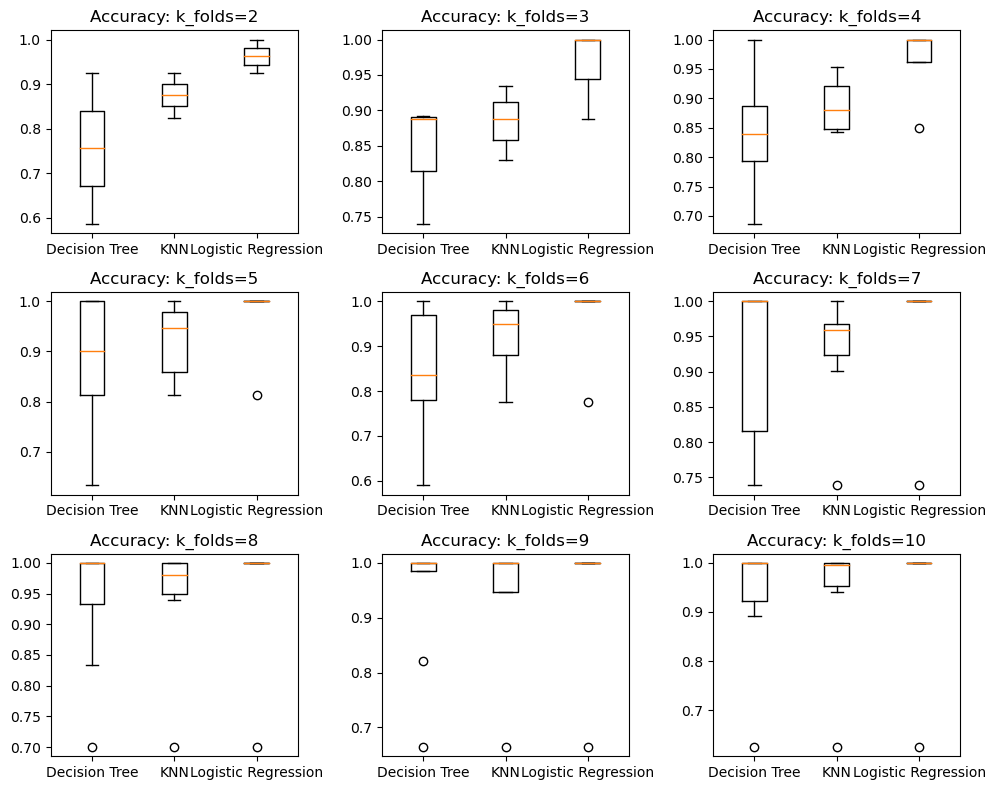

In [11]:
# Visualize Accuracy using k_folds 2 - 10
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))

axes = axes.flatten()

for idx, k_folds in enumerate(range(2, 11)):
    dt_accuracy = cross_val_score(dt_model, Xs_enc, y, cv=k_folds, scoring="accuracy")
    knn_accuracy = cross_val_score(knn_model, Xs_enc, y, cv=k_folds, scoring="accuracy")
    lr_accuracy = cross_val_score(lr_model, Xs_enc, y, cv=k_folds, scoring="accuracy")
    models = ["Decision Tree", "KNN", "Logistic Regression"]
    scores = [dt_accuracy, knn_accuracy, lr_accuracy]

    axes[idx].boxplot(scores, labels=models)
    axes[idx].set_title(f"Accuracy: k_folds={k_folds}")

plt.tight_layout()
plt.show()

### Observation

A comparison of all three models using cross-fold validation shows the variation of accuracy through different folds. 
Compared to the other two models, the logistic regression model is the most stable through the different k-fold values. 

## AUC-ROC Chart

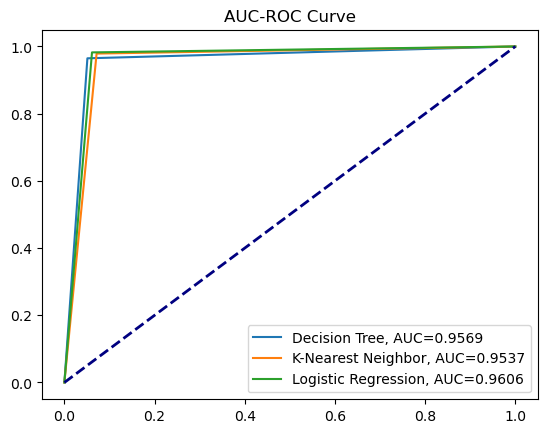

In [14]:
plt.figure()
jc.plot_roc(y_val, dty_pred, "Decision Tree")
jc.plot_roc(y_val, knny_pred, "K-Nearest Neighbor")
jc.plot_roc(y_val, lry_pred, "Logistic Regression")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("AUC-ROC Curve")
plt.xlabel = "False Positive Rate"
plt.ylabel = "True Positive Rate"
plt.legend(loc="lower right")
plt.show()

### Observation

Based on this curve, all three models appear to do very well. 
The Logistic Regression model has a slightly better AUC than KNN. 

# Final Results

Three machine learning models were developed and tested to predict placement status:
- Decision Tree
- K-Nearest Neighbor
- Logistic Regression

After comparing their performance across different evaluation metrics, the Logistic Regression model showed the best predictive accuracy and overall performance. Therefore, this model was selected for predicting placement status. 

In [19]:
intercept = np.round(lr_model.intercept_, 3)
coef = np.round(lr_model.coef_, 3)

print(f"Intercept (beta_0): {intercept}")
print(f"Coefficeints (beta_1, beta_2,..., beta_n): {coef}")

Intercept (beta_0): [-0.21]
Coefficeints (beta_1, beta_2,..., beta_n): [[ 0.     1.733  1.74  -1.241  1.766  0.   ]]


## Logistic Regression Equation

$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6)}}
$$
$$
\text{Where:} \quad \beta_0 = -0.210, \quad \beta_1 = 0, \quad \beta_2 = 1.733, \quad \beta_3 = 1.740, \quad \beta_4 = -1.241, \quad \beta_5 = 1.766, \quad \beta_6 = 0
$$
- x1: Employability_Before
- x2: Undergrad_Degree_Business
- x3: Undergrad_Degree_ComputerScience
- x4: Undergrad_Degree_Engineering
- x5: Undergrad_Degree_Finance
- x6: Work_Experience_Yes 


During the initial variable selection, a confidence level of 85% was used so that Employability_Before (p-value: 0.14486) could be included as a variable. After finalizing the model and reviewing the coefficients for the logistic regression equation, it is apparent that a confidence level of of 95% would have been just as appropriate. 

Based on the coefficients, Employability_Before and Work_Experrience_Yes are not significant in this equation (both coefficients are 0). Therefore, the key variable that determines a student's job placement status two months after graduation is their undegraduate degree. 

# Recommendations

## Continue Collecting Data

Continue gathering data on student job placements at multiple intervals, such as 4, 6, and 12 months after graduation, to continuously refine and improve the predictive model’s accuracy over time. 


## Data-Driven Approach to Admissions

Implement a data-driven admissions strategy by integrating insights from predictive models. This approach will prioritize candidates with the highest protential for job placement within two months of graduation. This will then help increase the school's graduate success rate. 


# Conclusion

Using a data-driven approach has the potential to improve admissions accuracy ensuring that the school continues to produce high graduation and employment placement rates, positioning the school as a prestigious, trustworthy school for prospective MBA students. 